In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from collections import Counter
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import sys
sys.path.append(r'C:\Users\Mud\Desktop\2ndPaper\lstm')
from model.lstmfcn import generate_lstmfcn
from model.fcn import generate_fcn
from model.lstm import generate_lstm
from utils.class_weight import compute_class_weight
import tensorflow as tf
import random as python_random

In [2]:
# # load the data
X_test_time = np.load(r'C:\Users\Mud\Desktop\2ndPaper\lstm\cultivar-specific\data\ries\X_test_ries.npy')
X_train_time = np.load(r'C:\Users\Mud\Desktop\2ndPaper\lstm\cultivar-specific\data\ries\X_train_ries.npy')
y_test = np.load(r'C:\Users\Mud\Desktop\2ndPaper\lstm\cultivar-specific\data\ries\y_test_ries.npy')
y_train = np.load(r'C:\Users\Mud\Desktop\2ndPaper\lstm\cultivar-specific\data\ries\y_train_ries.npy')
X_test_features = np.load(r'C:\Users\Mud\Desktop\2ndPaper\traditional_ml\weka\data\ries\X_test_ries.npy', allow_pickle=True)
X_train_features = np.load(r'C:\Users\Mud\Desktop\2ndPaper\traditional_ml\weka\data\ries\X_train_ries.npy', allow_pickle=True)

# # load fake data
#X_train = np.load('./fake/train/X_train.npy')
#y_train = np.load('./fake/train/y_train.npy')
#X_test = np.load('./fake/test/X_test.npy')
#y_test = np.load('./fake/test/y_test.npy')


print('X_train of time series shape:', X_train_time.shape)
print('X_test of time series shape:', X_test_time.shape)
print('X_train of features shape:', X_train_features.shape)
print('X_test of features shape:', X_test_features.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train of time series shape: (540, 600)
X_test of time series shape: (140, 600)
X_train of features shape: (540,)
X_test of features shape: (140,)
y_train shape: (540,)
y_test shape: (140,)


In [3]:
def reset_random_seeds(seed=42):
   np.random.seed(seed)
   python_random.seed(seed)
   tf.random.set_seed(seed)

reset_random_seeds()

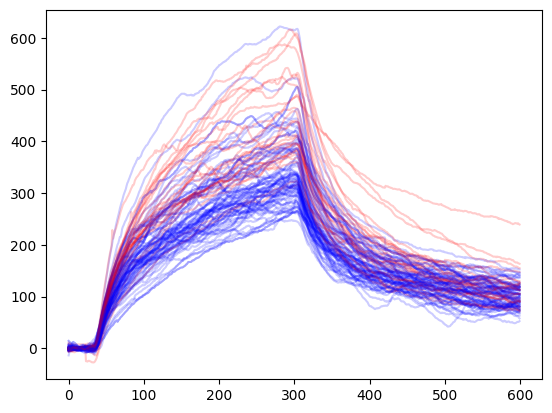

In [4]:
# normalize the data to have same starting pt for all time series
# input shape: (n_samples, n_timepoints), want each samples - its mean of 0-30th timepts
def normalize_curves_mean_method(unnormalized_datas):
    normalized_datas = []
    for unnormalized_data in unnormalized_datas:
        mean = np.mean(unnormalized_data[:30])
        normalized_data = unnormalized_data - mean
        normalized_datas.append(normalized_data)
    normalized_datas = np.array(normalized_datas)
    assert normalized_datas.shape == unnormalized_datas.shape
    return normalized_datas

# normalize the data using z-score, have mean 0 and std 1
def normalize_curves_zscore(unnormalized_datas):
    normalized_datas = []
    for unnormalized_data in unnormalized_datas:
        mean = np.mean(unnormalized_data)
        std = np.std(unnormalized_data)
        normalized_data = (unnormalized_data - mean) / std
        normalized_datas.append(normalized_data)
    normalized_datas = np.array(normalized_datas)
    assert normalized_datas.shape == unnormalized_datas.shape
    return normalized_datas


# apply ln() to the time series data
def apply_ln_to_curves(datas):
    ln_datas = []
    for data in datas:
        ln_data = np.log(data)
        ln_datas.append(ln_data)
    ln_datas = np.array(ln_datas)
    assert ln_datas.shape == datas.shape
    return ln_datas


# split the time series data into wanted time points
def split_time_series(datas, start, end):
    datas = datas[:, start:end]
    return datas


# plot the time series data, randomly picked n samples, different colors represent different classes
def plot_random_time_series(datas, n, labels):
    for i in range(n):
        idx = np.random.randint(datas.shape[0])
        plt.plot(datas[idx], color = 'blue' if labels[idx] == 1 else 'red', alpha = 0.2)
    plt.show()


X_train_time = normalize_curves_mean_method(X_train_time)
X_test_time = normalize_curves_mean_method(X_test_time)
plot_random_time_series(X_train_time, 100, y_train)

In [5]:
# normalize the features data
X_train_features = pd.DataFrame.from_records(X_train_features.flatten())
X_test_features = pd.DataFrame.from_records(X_test_features.flatten())
print(X_train_features.head(1))

scaler = StandardScaler()
features = X_train_features.columns
X_train_features[features] = scaler.fit_transform(X_train_features[features])
X_test_features[features] = scaler.transform(X_test_features[features])
print(X_train_features.head(1))

           pc0        pc1        pc2  rising_waveform  falling_waveform  \
0 -1320.506845  47.462699  39.931146         0.965372          0.547959   

   peak_temperature  cultivar  
0        260.650491         1  
        pc0       pc1       pc2  rising_waveform  falling_waveform  \
0 -1.301383  0.182964  0.410809        -1.356883         -1.452817   

   peak_temperature  cultivar  
0         -1.356883       0.0  


In [6]:
# normalize the time series data
# compute mean & std of the training set, then normalize the whole dataset using z-normalization
mean = np.mean(X_train_time)
std = np.std(X_train_time)
X_train_time = (X_train_time - mean) / std
X_test_time = (X_test_time - mean) / std

In [7]:
# Ensure data is shaped correctly
X_train_time = X_train_time.reshape(-1, 1, 600)  # Convert to (samples, 1, timesteps)
X_test_time = X_test_time.reshape(-1, 1, 600)
y_train = y_train.reshape(-1, 1)  # Ensure labels are in shape (samples, 1)
y_test = y_test.reshape(-1, 1)
X_train_features = X_train_features.values
X_test_features = X_test_features.values

print('X_train shape of time series:', X_train_time.shape)
print('y_train shape:', y_train.shape)
print('X_test shape of time series:', X_test_time.shape)
print('y_test shape:', y_test.shape)
print('X_train shape of features:', X_train_features.shape)
print('X_test shape of features:', X_test_features.shape)

X_train shape of time series: (540, 1, 600)
y_train shape: (540, 1)
X_test shape of time series: (140, 1, 600)
y_test shape: (140, 1)
X_train shape of features: (540, 7)
X_test shape of features: (140, 7)


class_weights: [1.86206897 0.6835443 ]
X_train shape of time series: (432, 1, 600)
y_train shape: (432, 1)
X_val shape of time series: (108, 1, 600)
y_val shape: (108, 1)
X_train shape of features: (432, 7)
X_val shape of features: (108, 7)
Epoch 1/1100
27/27 [==============================] - 1s 11ms/step - loss: 0.6562 - accuracy: 0.5880 - val_loss: 0.6891 - val_accuracy: 0.5185 - lr: 8.0000e-06
Epoch 2/1100
27/27 [==============================] - 0s 2ms/step - loss: 0.6530 - accuracy: 0.5694 - val_loss: 0.6824 - val_accuracy: 0.5556 - lr: 8.0000e-06
Epoch 3/1100
27/27 [==============================] - 0s 2ms/step - loss: 0.6471 - accuracy: 0.6019 - val_loss: 0.6753 - val_accuracy: 0.5833 - lr: 8.0000e-06
Epoch 4/1100
27/27 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 0.6065 - val_loss: 0.6684 - val_accuracy: 0.6111 - lr: 8.0000e-06
Epoch 5/1100
27/27 [==============================] - 0s 2ms/step - loss: 0.6375 - accuracy: 0.6574 - val_loss: 0.6608 - v

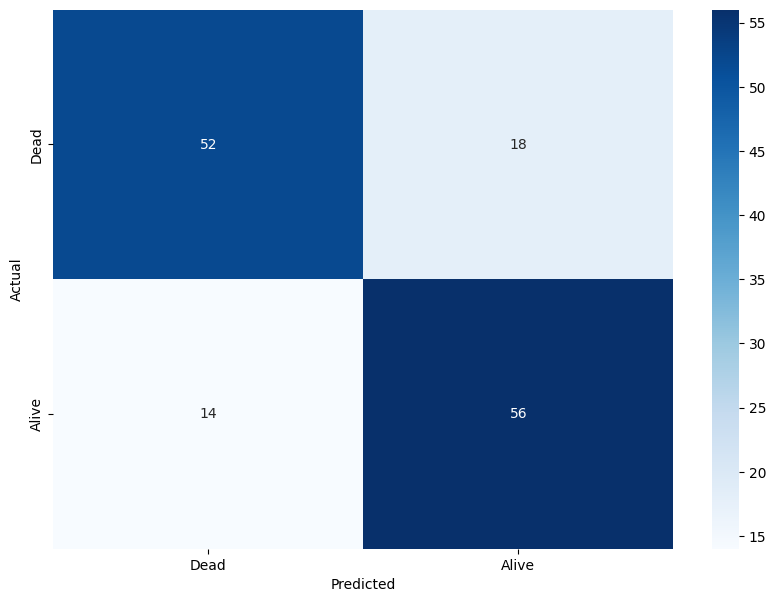

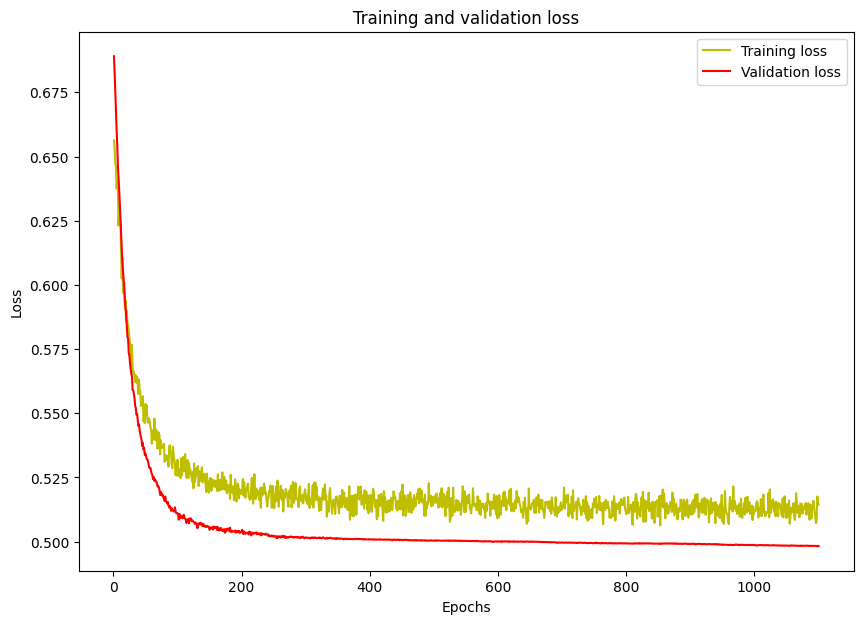

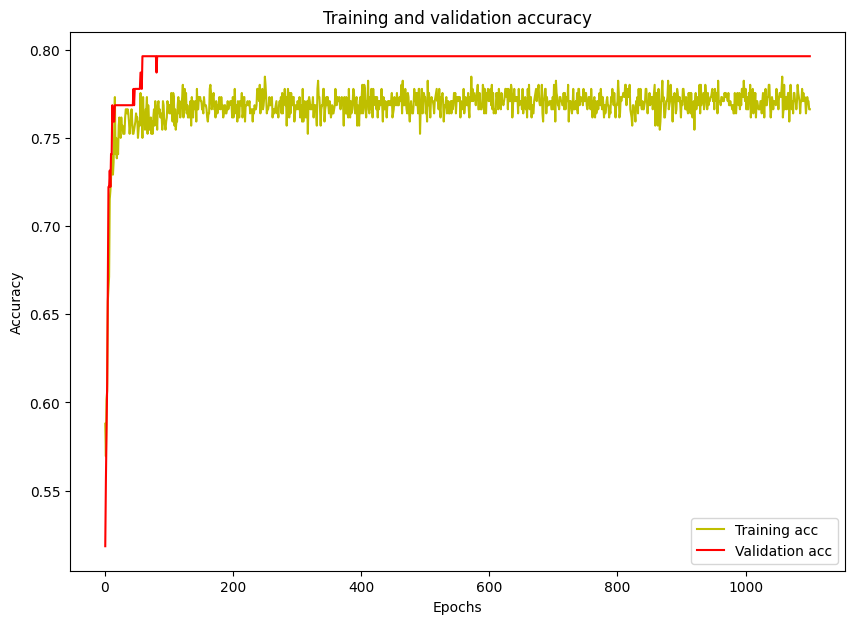

In [8]:
# Train final model on full training data# Initialize model
final_model = generate_lstm(feature_input_accept=True, dropout=0.0)
class_weights = compute_class_weight(y_train)
print('class_weights:', class_weights)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=15, mode='auto',
    factor=1. / np.cbrt(2), cooldown=0, min_lr=5e-7, verbose=2)
final_model.compile(optimizer=Adam(learning_rate=8e-6), loss='binary_crossentropy', metrics=['accuracy'])

# split the data into training and validation set
X_train_time, X_val_time, X_train_features, X_val_features, y_train, y_val = train_test_split(
    X_train_time, X_train_features, y_train, test_size=0.2, random_state=42)
print('X_train shape of time series:', X_train_time.shape)
print('y_train shape:', y_train.shape)
print('X_val shape of time series:', X_val_time.shape)
print('y_val shape:', y_val.shape)
print('X_train shape of features:', X_train_features.shape)
print('X_val shape of features:', X_val_features.shape)

# Train model
history = final_model.fit(
    [X_train_time, X_train_features], y_train,
    validation_data=([X_val_time, X_val_features], y_val),
    callbacks=[reduce_lr],
    epochs=1100, batch_size=16, class_weight={0: class_weights[0], 1: class_weights[1]},
    verbose=1
)

# Predict on test set
y_pred_prob = final_model.predict([X_test_time, X_test_features])
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# plot the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test ROC AUC Score: {roc_auc:.4f}")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dead', 'Alive'], yticklabels=['Dead', 'Alive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 7))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(10, 7))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()